In [1]:
#| default_exp learner

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *

from fastprogress import progress_bar,master_bar

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

Note that included now is the fastprogress bar and also the fastcore.test, test_close function

## Learner 

### Setup data and dataloader.  
Mnist fashion will be used again but in this case for a classification problem rather than as an autoencode as in the last notebook

In [4]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [6]:
bs = 1024
tds = dsd.with_transform(transformi)

In [7]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [8]:
#|export
class DataLoaders:
    """ Class to create train and validate dataloaders from a dataset
    """
    
    def __init__(self, *dls): self.train, self.valid = dls[:2]
    
    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds), **kwargs) for ds in dd.values()]) 

In [9]:
dls = DataLoaders.from_dd(tds, batch_size=bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb[:16].shape, yb[:16]

(torch.Size([16, 784]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

### Basic Learner

Start of with a basic but limited and rigid model, which will then be developed to facilitate additional features to optimise the training

In [10]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()
    
    def one_batch(self):
        """ Calculate the predictions and loss for the batch.  If training then carry out optimisation
        calculate stats for the batch
        """
        self.xb, self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()
        
        
    def calc_stats(self):
        """ Calculate accuracy, losses and number of sample in a batch and append to summary lists
        """
        acc = (self.preds.argmax(dim=1) == self.yb).float().sum()
        self.acc.append(acc)
        nb = len(xb)
        self.ns.append(nb)
        self.losses.append(self.loss*nb)
        
        
    
    def one_epoch(self, train):
        """ Execute one epoch in either train or eval mode
        Execute all batches
        Print training accuracy and progress
        """
        self.model.training = train
        dl = dls.train if train else self.dls.valid
        n = len(dl)
        for self.batch_num, self.batch in enumerate(dl):
            self.one_batch()
        total_samples = sum(self.ns)
        print(f'{self.epoch},  {self.model.training}, {sum(self.losses).item()/total_samples}, {sum(self.acc).item()/total_samples}')
        #
    
    def fit(self, n_epochs):
        """ train and evaluate model over n_epochs.  To do so:
        Create optimizer
        Create empyt lists for losses, accuracy and number if samples
        Send the model to the correct device
        Iterate through each epoch for train and then eval
        """
        self.acc, self.losses, self.ns = [], [], []
        self.model.to(def_device)
        self.opt = optim.SGD(self.model.parameters(), lr=self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(train=True)
            self.one_epoch(train=False)    

In [11]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [12]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0,  True, 1.182267787092823, 0.5915320444915254
0,  False, 1.131643433501755, 0.6031476449275363


### Basic Callbacks Learner

The first step to make the training more flexible is to add callbacks.  These allow the model training to be interupted and changed as required.  The callback concept will make use of Exceptions, which are a powerful way in which to manage execution flow

In [13]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [14]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        # if there is a callback with the name then return it else return None
        method = getattr(cb, method_nm, None)
        # if the callback is not None then execute it
        if method is not None: method(learn)

Create a callback class that can be inherited by actual callbacks

In [15]:
#|export
class Callback(): order = 0

In [16]:
class CompletionCB(Callback):
    """ Callback to track and print out the number of batches
    """
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

To run the callback it is wrapped as a list and then executed using the run_cbs function

In [17]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


The learner can be updated to call the callbacks before_batch,  after_batch, before_epoch, after epochs, before_fit, after_fit.  The epoch, batch and fit can be terminated by any of the callback raising a Cancel Exception

To enable this the learner has to be passed the callback.  Also each callback is passed an attribute learn that contains the learner, hence the callback has access to all of the learner attributes

In [18]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        # Assign the learner with all of its attributes to each of the callbacks
        for cb in cbs: cb.learn = self
            
    def one_batch(self):
        self.xb, self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            
    def one_epoch(self, train):
        """ Execute one epoch in either train or eval mode
        Execute all batches
        Print training accuracy and progress
        """
        # Why are these two lines before the "before_epoch" try?
        self.model.training = train
        dl = dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            n = len(dl)
            for self.batch_num, self.batch in enumerate(dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass    
            self.callback('after_epoch')
        except CancelEpochException: pass
            
    
    def fit(self, n_epochs):
        """ train and evaluate model over n_epochs.  To do so:
        Create optimizer
        Send the model to the correct device
        Iterate through each epoch for train and then eval
        """
        self.model.to(def_device)
        self.opt = optim.SGD(self.model.parameters(), lr=self.lr)
        try:
            self.callback('before_fit')
            self.n_epochs = n_epochs
            for self.epoch in range(n_epochs):
                self.one_epoch(train=True)
                self.one_epoch(train=False)
            self.callback('after_fit')
        except CancelFitException: pass
    
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)

In [19]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [20]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 69 batches


In [21]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

## Add in the Metrics 

Firstly create a generic class that all metrics can inherit

In [22]:
class Metric:
    """ Class to store accumulated metrics and to then calculate the value when required.  Values will all
    be stored in self.vals, number of samples in self.ns
    
    Classes inheriting from this will overwrite the calc method
    
    Assumes that the metrics will be returned as means and not sums
    """
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.vals, self.ns = [], []
        
    def add(self, 
            inp, # inputs to use to calculate metrics (usually the preds)
            targ=None, # targets to compare preds against
            n=1 # number of samples (usually size of the batch)
           ):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals) * ns).sum() / ns.sum()
    
    def calc(self, inps, targs):
        """ To be overwritten by inherited classes
        """
        return inps   

Use the above class to calculate the accuracy metric

In [23]:
class Accuracy(Metric):
    def calc(self, inps, targs):
        acc = (inps == targs).float().mean()
        return acc

In [24]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]), 6)
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]), 5)
acc.value

tensor(0.45)

In [25]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

### Add some basic callbacks to move model and data to the correct device

In [26]:
#|export
class DeviceCB(Callback):
    def before_fit(self, learn):
        learn.model.to(def_device)
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, def_device)

The above metrics can be replaced by the torcheval library.  Instead of the above methods it has .update, .compute and .reset

In [27]:
#|export
from torcheval.metrics import MulticlassAccuracy, Mean

In [28]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [29]:
metric.reset()
metric.compute()

tensor(nan)

Develop a metrics callback that allows any required metrics to be calculated as part of the training process using callbacks

This requires a function to move any tensors back to the cpu to make processing easier

In [30]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
        # Assign the learner with all of its attributes to each of the callbacks
        for cb in cbs: cb.learn = self
            
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
            
    def one_epoch(self, train):
        """ Execute one epoch in either train or eval mode
        Execute all batches
        Print training accuracy and progress
        """
        # Why are these two lines before the "before_epoch" try?
        self.model.training = train
        dl = dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            n = len(dl)
            for self.batch_num, self.batch in enumerate(dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass    
            self.callback('after_epoch')
        except CancelEpochException: pass
            
    
    def fit(self, n_epochs):
        """ train and evaluate model over n_epochs.  To do so:
        Create optimizer
        Send the model to the correct device
        Iterate through each epoch for train and then eval
        """
        self.model.to(def_device)
        self.opt = optim.SGD(self.model.parameters(), lr=self.lr)
        try:
            self.callback('before_fit')
            self.n_epochs = n_epochs
            for self.epoch in range(n_epochs):
                self.one_epoch(train=True)
                self.one_epoch(train=False)
            self.callback('after_fit')
        except CancelFitException: pass
    
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)

In [31]:
#|export
def to_cpu(x):
    """recursive function that breaks lists and tuples into individual items moves them to the cpu
    and then returns the original item with all of the parts moved
    """
    if isinstance(x, Mapping): return {k: to_cpu(v) for k, v in x.items()}
    if isinstance(x, list): return [to_cpu(v) for v in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [32]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        # Assign all metrics supplied as list items to attributes
        for o in ms:
            # Create a metrics dictionary to facilitate easy access
            metrics[type(o).__name__()] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    
    def _log(self, 
             d # list of metrics to print for each epoch
            ):
        """ Print summary of the logs every epoch
        """
        print(self.learn.epoch, self.learn.model.training, d)
        
    def before_fit(self, learn):
        # Assign this metrics instance to the learner
        learn.metrics = self
        
    def before_epoch(self, learn):
        # Reset metrics
        [o.reset() for o in self.all_metrics.values()]
        
    def after_epoch(self, learn):
        # Print summary of metrics
        log = {k: f'{v.compute():.3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = learn.model.training
        # Trigger printing of the metrics
        self._log(log)
        
    def after_batch(self, learn):
        # Update metrics
        # put x, and y onto cpu
        x, y  = to_cpu(learn.batch)
        # put preds onto cpu and calculate metric for each metric
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        # update the loss (Note that loss has been instantiated from the Mean class where the weight is used)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
        

In [33]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

0 True {'accuracy': '0.603', 'loss': '1.182', 'epoch': 0, 'train': True}
0 False {'accuracy': '0.690', 'loss': '0.849', 'epoch': 0, 'train': False}


### Flexible Learner
To make the learner more flexible use can be made of a context manager. This allows linking of before and after callbacks for a specific part of training.  The before is called when the context manager is applied, and the after when the contect manager exits

In [34]:
@contextmanager
def callback_ctx(cbmeth, nm):
    try:
        cbmeth(f'before_{nm}')
        yield
        cbmeth(f'after_{nm}')
    except globals()[f'Cancel{nm.title()}Exception']: pass
    finally: cbmeth(f'cleanup_{nm}')

In [35]:
#|export
class Learner():
    def __init__(self, model, dls, loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        self.cb_ctx = partial(callback_ctx, self.callback)
        fc.store_attr()        
                                 
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
            
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        """ train and evaluate model over n_epochs.  To do so:
        Create optimizer
        Send the model to the correct device
        Iterate through each epoch for train and then eval
        """
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(train=True)
                    if valid:
                        with torch.no_grad():
                            self.one_epoch(train=False)
        finally:
            for cb in cbs: self.cbs.remove(cb)
                
    def __getattr__(self, name):
        """ by setting this up the functions named below become additional callbacks
        """
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)
        
    @property
    def training(self): return self.model.training
    

The above requires the callbacks mentioned to be put in place.  It is also desirable to add a progress callback so that the status of training can be seen

In [36]:
#|export
class ProgressCB(Callback):
    """ Need to make sure that this callback is higher in the order than the metrics callback so that results 
    are updated.
    
    The progress callbar will both plot a bar of the progress through the epochs and also a sub bar of 
    progress through the batches of an epoch
    
    It also outputs a summary of loss and updates the plot after each batch
    
    """
    order = MetricsCB.order + 1
    
    def __init__(self, plot=False): self.plot=plot
        
    def before_fit(self, learn):
        # Replace epochs with the master bar to enable plotting progress
        learn.epochs = self.mbar = master_bar(learn.epochs)
        # Replace teh learner metrics log with the log from this class
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        
    def _log(self, d):
        """ Write the metrics and loss to the output
        """
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first=False
        self.mbar.write(list(d.values()), table=True)
    
    def before_epoch(self, learn):
        """ Setup the second progress bar for the batches
        """
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    
    def after_batch(self, learn):
        learn.dl.comment = f"{learn.loss:.3f}"
        if self.plot and hasattr(learn, 'metrics') and learn.model.training:
            self.losses.append(learn.loss.item())
            # when a collection or list is passed to fc.L.range it returns a range that is based upon the 
            # length of the collection
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [37]:
#|export
class TrainCB(Callback):
    def predict(self, learn): learn.preds = learn.model(learn.batch[0])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, learn.batch[1])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

Test the learner and callbacks

In [38]:
model = get_model()

In [39]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [40]:
fc.L(cbs)

(#4) [<__main__.TrainCB object at 0x7fb6ad3089a0>,<__main__.DeviceCB object at 0x7fb6ad308b20>,<__main__.MetricsCB object at 0x7fb6ad3084f0>,<__main__.ProgressCB object at 0x7fb6ad1aef70>]

accuracy,loss,epoch,train
0.610,1.154,0,True
0.681,0.839,0,False


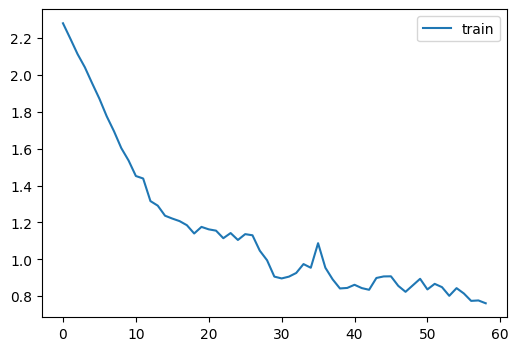

In [41]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

### TrainLearner and MomentumLearner subclass
This model demonstrates that rather than resetting the gradients after every optimisation step, it is possible to retain a proportion of them and build the next iteration starting from that point, which is more or less equivalent to a momentum model

In [42]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [46]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom=mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.673,0.951,0,True
0.809,0.534,0,False


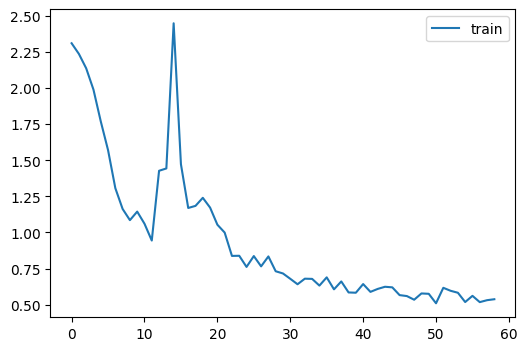

In [47]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

### LRFinderDB

In [48]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.losses, self.lrs = [], []
        self.min = math.inf
        
    def after_batch(self, learn):
        # add lr and loss to lists
        # update plot
        # check whether to continue, if so
        # update lr, 
        if not learn.model.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min=loss
        # test of starting to become unstable
        if loss > self.min * 3: raise CancelFitException()
        # update the learning rates in the param_groups
        for group in learn.opt.param_groups:
            group['lr'] *= self.lr_mult

In [49]:
lrfinder = LRFinderCB()
cbs = [DeviceCB(), metrics, ProgressCB(), lrfinder]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1.e-3, cbs=cbs)
learn.fit(1)

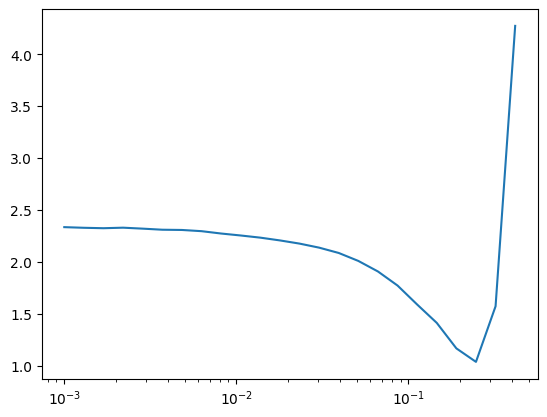

In [50]:
plt.plot(lrfinder.lrs, lrfinder.losses)
plt.xscale('log')

The above can be improved by using the ExponentialLR scheduler built into Pytorch

In [51]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

In [53]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.losses, self.lrs = [], []
        self.sched = ExponentialLR(learn.opt, gamma=self.gamma)
        self.min = math.inf
        
    def after_batch(self, learn):
        # add lr and loss to lists
        # update plot
        # check whether to continue, if so
        # update lr, 
        if not learn.model.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min=loss
        # test of starting to become unstable
        if loss > self.min * self.max_mult: raise CancelFitException()
        # update the learning rates in the param_groups
        self.sched.step()
        
    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

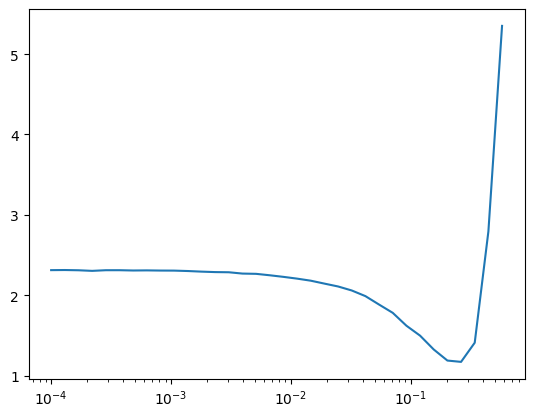

In [54]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), ProgressCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)

In [56]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

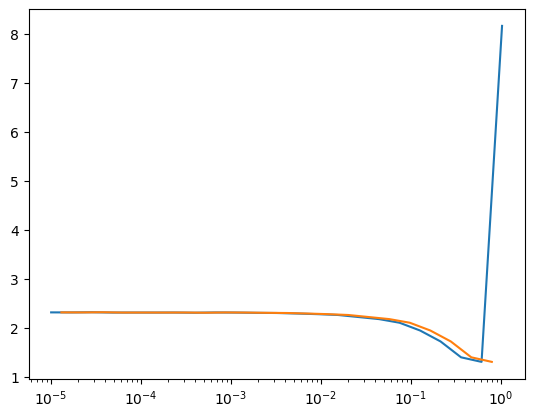

In [57]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find(max_mult=3)

## Updated versions since the lesson

After the lesson we noticed that `contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`. Therefore we've replaced the context manager with this one:

In [58]:
#| export
class callback_ctx:
    def __init__(self, cbmeth, nm): self.nm,self.cbmeth = nm,cbmeth
    def __enter__(self): self.cbmeth(f'before_{self.nm}')
    def __exit__ (self, exc_type, exc_val, traceback):
        chk_exc = globals()[f'Cancel{self.nm.title()}Exception']
        try:
            if not exc_type: self.cbmeth(f'after_{self.nm}')
            return exc_type==chk_exc
        except chk_exc: pass
        finally: self.cbmeth(f'cleanup_{self.nm}')

## Export 

In [1]:
import nbdev; nbdev.nbdev_export()